<a href="https://colab.research.google.com/github/daisea3e1203/soco_fashion_dnn/blob/main/03_dev_gradcam_on_representation_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


# Import

In [2]:
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

# Config


In [4]:
target_size = 32  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 20  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

# Prepare Data

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

print("x_data shape:", x_data.shape, "- y_data shape:", y_data.shape)

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

170508288/170498071 [==============================] - 3s 0us/step
x_data shape: (60000, 32, 32, 3) - y_data shape: (60000, 1)


In [5]:
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(target_size, target_size),
        layers.Normalization(),
    ]
)
# Compute the mean and the variance from the data for normalization.
data_preprocessing.layers[-1].adapt(x_data)

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(
            factor=0.15, fill_mode="nearest"
        ),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        )
    ]
)

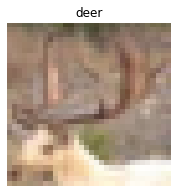

In [7]:
# Sanity check: display random image
image_idx = np.random.choice(range(x_data.shape[0]))
image = x_data[image_idx]
image_class = classes[y_data[image_idx][0]]
plt.figure(figsize=(3, 3))
plt.imshow(x_data[image_idx].astype("uint8"))
plt.title(image_class)
_ = plt.axis("off")

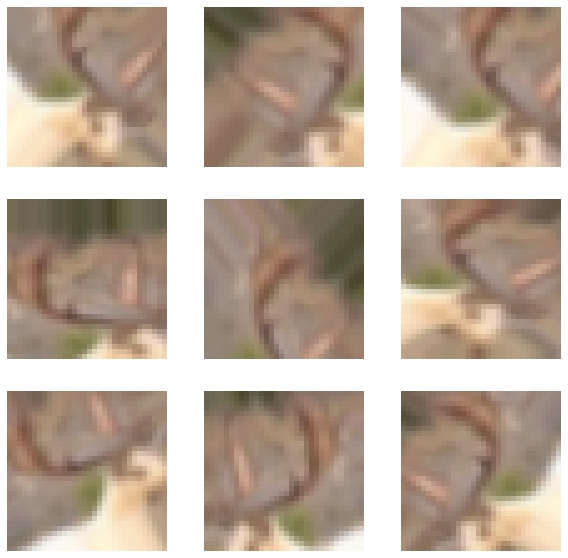

In [8]:
# Sanity check: display augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(np.array([image]))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Implement Model

## Vision Encoder


In [10]:
def create_encoder(representation_dim):
    # inputs = keras.Input(shape=(32,32,3))
    # x = keras.applications.ResNet50V2(input_tensor=inputs, include_top=False, weights=None, pooling="avg")
    # x = layers.Dense(representation_dim)(x.output)
    # encoder = keras.Model(inputs, x)
    
    return encoder

    encoder = keras.Sequential(
        [
            keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling="avg"
            ),
            layers.Dense(representation_dim),
        ]
    )
    return encoder

## Unsupervised Contrastive Loss

In [9]:
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super(RepresentationLearner, self).__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = tf.math.reduce_max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head.
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# Train model

In [11]:
# Create vision encoder.
encoder = create_encoder(representation_dim)
# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
# Create a a Cosine decay learning rate scheduler.
lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)
# Compile the model.
representation_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
)
# Fit the model.
history = representation_learner.fit(
    x=x_data,
    batch_size=512,
    epochs=50,  # for better results, increase the number of epochs to 500.
)

Epoch 1/50
118/118 [==============================] - 76s 371ms/step - loss: 53.9021
Epoch 2/50
118/118 [==============================] - 41s 351ms/step - loss: 11.9619
Epoch 3/50
118/118 [==============================] - 41s 349ms/step - loss: 11.5124
Epoch 4/50
118/118 [==============================] - 41s 350ms/step - loss: 11.2425
Epoch 5/50
118/118 [==============================] - 41s 350ms/step - loss: 11.1091
Epoch 6/50
118/118 [==============================] - 41s 349ms/step - loss: 11.0168
Epoch 7/50
118/118 [==============================] - 41s 352ms/step - loss: 10.8718
Epoch 8/50
118/118 [==============================] - 41s 351ms/step - loss: 10.7582
Epoch 9/50
118/118 [==============================] - 41s 350ms/step - loss: 10.6322
Epoch 10/50
118/118 [==============================] - 41s 350ms/step - loss: 10.4945
Epoch 11/50
118/118 [==============================] - 41s 350ms/step - loss: 10.3356
Epoch 12/50
118/118 [==============================] - 41s 350m

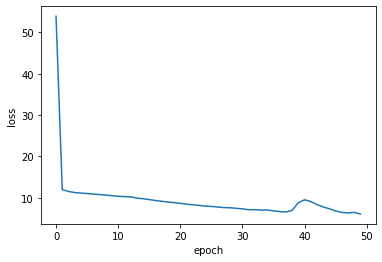

In [12]:
# Sanity check: plot loss transition
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [38]:
# Summarize model
representation_learner.summary()

Model: "representation_learner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 512)               24613888  
                                                                 
 sequential_3 (Sequential)   (None, 128)               66048     
                                                                 
Total params: 24,679,938
Trainable params: 24,634,240
Non-trainable params: 45,698
_________________________________________________________________


In [51]:
representation_learner.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
Total params: 24,613,888
Trainable params: 24,568,448
Non-trainable params: 45,440
_________________________________________________________________


# Save model

In [83]:
representation_learner.save_weights('/content/drive/MyDrive/Soco/Fashion/models/0720/model.weights')

# Check Attention using Gradcam 

## Calculate Heatmap

In [58]:
from keras.layers import Input

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_output_ph, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions

    m = model
    
    grad_model = tf.keras.models.Model(
        [m.inputs], 
        [
            # m.get_layer(last_conv_layer_name).output,
            last_conv_layer_output_ph,
            # m.get_layer('dense').outputs
            m.outputs
        ]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            # ? if pred_index is not specified, get the index of the channel with the highest activation
            pred_index = tf.argmax(preds[0][0])
        class_channel = preds[0][0][pred_index]
        
        # print(preds[0][0])
        # print("class_channel")
        # print(class_channel)
        # print("preds")
        # print(len(preds))
        # print(len(preds[0]))
        # print(len(preds[0][0]))

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    print(grads.shape)
    print(grads[0])
    # print(grads[0][0][0])
    # print("grads")
    # print(grads)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # print("pooled")
    # print(pooled_grads)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation

    # print(last_conv_layer_output.shape)
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [89]:
def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        
        print(last_conv_layer_output.shape)
        print(preds.shape)

        if pred_index is None:
            # ? if pred_index is not specified, get the index of the channel with the highest activation
            pred_index = tf.argmax(preds[0])
        class_channel = preds[0][pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    print(grads.shape)
    # print(grads[0])
    # print(grads[0][0][0])
    # print("grads")
    # print(grads)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # print("pooled")
    print(pooled_grads.shape)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation

    # print(last_conv_layer_output.shape)
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [90]:
img = x_data[0].reshape(1, target_size, target_size, 3)

layer_name = "conv2_block3_1_relu"
target_model = representation_learner.encoder
# resnet = target_model.get_layer('resnet50v2')
resnet = target_model.layers[0]

grad_sub_model = tf.keras.models.Model(
    inputs=resnet.input,
    outputs=[resnet.get_layer(layer_name).output, resnet.output]
)

# contruct grad model
inputs = grad_sub_model.inputs
tmp, preds = grad_sub_model(inputs)
preds = target_model.layers[1](preds)
grad_model = tf.keras.models.Model(inputs, [tmp, preds])


heatmap = make_gradcam_heatmap(img, grad_model) # this isn't the last conv layer, but it had a nice response

(1, 8, 8, 64)
(1, 512)
(1, 8, 8, 64)
(64,)


In [94]:
# Sanity check: check the output isn't 0
representation_learner(img).shape

TensorShape([2, 128])

In [32]:
# Sanity check: print grad and check there's atleast one feature that is not 0

img = x_data[0].reshape(1, target_size, target_size, 3)
layer_name = "dense_1"
target_model = representation_learner.projector
last_layer_output_ph = target_model.get_layer(layer_name).output

heatmap = make_gradcam_heatmap(representation_learner.encoder(img), target_model, last_layer_output_ph) # this isn't the last conv layer, but it had a nice response

(1, 128)
tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.17034726
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.   

InvalidArgumentError: ignored

## Plot heat map

In [92]:
import numpy as np
import matplotlib.cm as cm

def display_image(img_array, heatmap_array, alpha=0.4):
    heatmap = np.uint8(255 * heatmap_array)
    
    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array
    # superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    

    plt.matshow(jet_heatmap/255)
    plt.matshow(img_array/255)
    plt.matshow(superimposed_img/255)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))

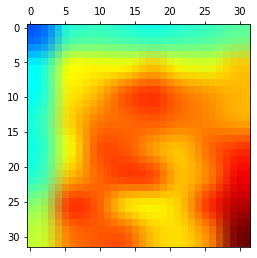

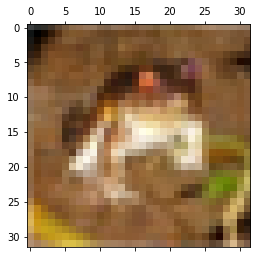

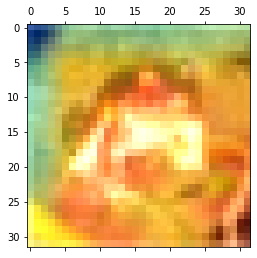

In [93]:
display_image(img.reshape(32,32,3), heatmap)